# OpenFE Showcase : Relative Binding Free Energy calculation of T4 lysozyme ligand using OpenMM

This notebook demonstrates the current capabilities of the OpenFE toolkit. Here
we specifically look at how relative binding free energy calculations can be
carried out using the OpenMM MD engine in combination with the OpenFE toolset.
This notebook will be continually updated as OpenFE introduces new features.

## 1. Overview

### Relative binding free energies of small ligands complexed to T4-lysozyme L99A mutant

In this example we look how one could set up a network of transformations using
the OpenFE toolkit for small chemical modifications of an initial known
binder, benzene, to T4-lysozyme L99A.

Crystallographic and affinity data (dG of -5.2 kcal/mol) are available for
benzene and demonstrate the ligand to bind within the lipophylic cavity of
T4-lysozyme L99A.

In [1]:
# Let's visualise the known protein-ligand complex
# We use MDAnalysis to fetch the 181L complex and nglview to visualise it
import MDAnalysis as mda
import nglview as nv

u = mda.fetch_mmtf('181L')
view = nv.show_mdanalysis(u)
view.display()
view

NGLWidget()

For convenience, a prepared (capped and protonated) PDB structure of the
T4-lysozyme L994A protein is provided under `inputs/181L_mod_capped_protonated.pdb`.

### Alchemical transformations of benzene

Chemical modifications benzene binding to T4 lysozyme are relatively well
studied, examples can be seen in the works of [Mobley et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2104542/) and [Gapsys et al.](https://www.nature.com/articles/s42004-021-00498-y#Fig1). Here we explore how OpenFE can be used
to build a simple star map network for planned alchemical substitutions of the
core benzene ring.

Five pre-aligned compounds (phenol, toluene, anisole, styrene, benzonitrile,
and benzaldehyde) and the benzene core are available under
`inputs/ligands.sdf`. These are shown in the cell below.

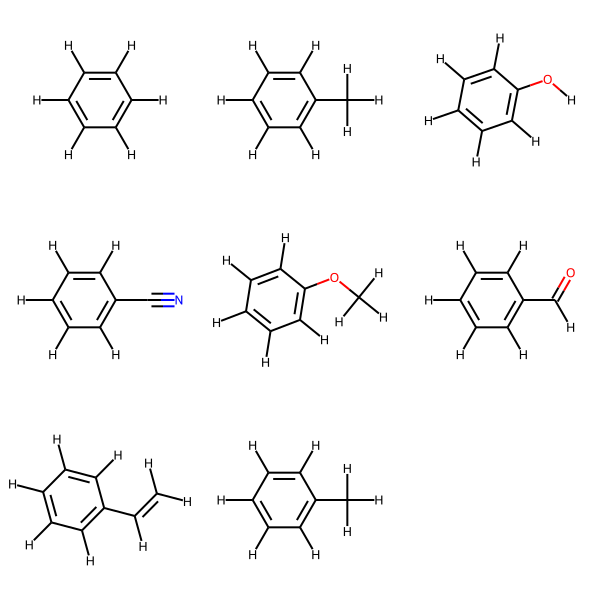

In [2]:
# Let's have a look at our ligands

from rdkit import Chem
from rdkit.Chem import AllChem

# Extract the contents of the sdf file and visualise it
ligands_rdmol = [mol for mol in
                 Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=False)]

for ligand in ligands_rdmol:
    AllChem.Compute2DCoords(ligand)

Chem.Draw.MolsToGridImage(ligands_rdmol)

Ultimately we will limit the RBFEs done in this notebook to the transformation
of benzene to phenol, as similarly done in the [AMBER free energy tutorial](https://ambermd.org/tutorials/advanced/tutorial9/index.html#home). Previous work has
shown that phenol does not bind to T4-Lysozyme L99A, so we expect that the RBFE
will capture the positive change in the free energy.

### The plan

Here is what we will achieve in this notebook and what software toolchains are
used along the way.

| **Actions**                    | **Software**                                                |
|:------------------------------:|:-----------------------------------------------------------:|
| Create OpenFE Molecules        | OpenFE tk, RDKit                                            |
| Create Radial Network          | OpenFE tk, Lomap, Networkx                                  |
| Visualise Netwwork             | OpenFE tk, NetworkX, RDKit, Matplotlib                      | 
| Create ligand topologies       | OpenFE tk interface - OpenFF tk                             |
| Create hybrid OpenMM topology  | OpenFE tk interface - OpenMMTools (eventually - ex Perses)  |
| Create Lambda Protocol         | OpenFE tk interface - OpenMMTools (eventually - ex Perses)  |
| Setup and run RBFE calculation | OpenFE tk interface - OpenMM + OpenMMTools                  |
| Analysis RBFE calculation      | OpenFE tk interface - PyMBAR + OpenMMTools                  |


A complete overview of the setup and simulation process starting from initial SDF and PDB files can be found [in this diagram](./assets/RBFE_workflow.drawio.pdf).

## 2. Creating a transformation network

### Creating OpenFE SmallMoleculeComponents

In order to keep track of the various inputs being passed through the OpenFE
toolkit, OpenFE implements a set of Components which define the proteins,
small molecules and solvent components which a system may contain. Here we
use the [SmallMoleculeComponent](https://github.com/OpenFreeEnergy/gufe/blob/main/gufe/smallmoleculecomponent.py)
which takes in either [RDKit molecules](https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html)
or [OpenFF molecules](https://open-forcefield-toolkit.readthedocs.io/en/0.9.2/api/generated/openff.toolkit.topology.Molecule.html).

In the backend, OpenFE treats the RDKit molecules as the central representation
of the ligands, and uses the OpenFF toolkit to convert between objects from
various toolchains (for example OpenEye's OEMol).

Here we demonstrate how to load the ligands from `inputs/ligands.sdf` into a
list of OpenFE SmallMoleculeComponents for further processing.

In [3]:
from openfe.setup import SmallMoleculeComponent

# Create and SDF supplier
# Extract the contents of the sdf file and visualise it
ligands_sdf = Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=False)

# Now pass these to form a list of Molecules
ligand_mols = [SmallMoleculeComponent(sdf) for sdf in ligands_sdf]

OpenFE SmallMoleculeComponents have some useful built in attributes and methods.

For example the molecule's name (as defined by the SDF file) can be accessed

In [4]:
print("name: ", ligand_mols[0].name)

name:  benzene


SmallMoleculeComponents also have a means of hashing based on the molecule smiles so as to aid in tasks such as serialisation

In [5]:
print("hash: ", ligand_mols[0]._hash)

hash:  MoleculeHash(smiles='[H]c1c([H])c([H])c([H])c([H])c1[H]', name='benzene')


As previously stated SmallMoleculeComponents also use the OpenFF backend to allow conversion between different object types. For example it's possible to obtain an openff Molecule:

In [6]:
type(ligand_mols[0].to_openff())

openff.toolkit.topology.molecule.Molecule

### Creating a network

From these SmallMoleculeComponents we can quickly create a star map network which centers
around the first ligand in our sdf file (benzene) using
`openfe.setup.ligand_network_planning.generate_radial_network`.

Here we use Lomap (via the OpenFE interface LomapAtomMapper) to define the atom mappings between the various ligands and the central benzene structure. Whilst
we use the defaults here, please note that the various supported arguments of
Lomap can be passed to LomapAtomMapper.

Note: LomapAtomMapper is currently the only implemented Mapper in OpenFE,
however in future work we will look to implement various other ones, such as
the rjmc mapper from Perses. Long term, users will be able to pass serveral
mappers and atom mapping scoring methods on network generation.

In [7]:
# Create network from the two molecules
from openfe.setup.ligand_network_planning import generate_radial_network
from openfe.setup.lomap_mapper import LomapAtomMapper

network = generate_radial_network(ligands=ligand_mols[1:],
                                  central_ligand=ligand_mols[0],
                                  mappers=[LomapAtomMapper(threed=True),])

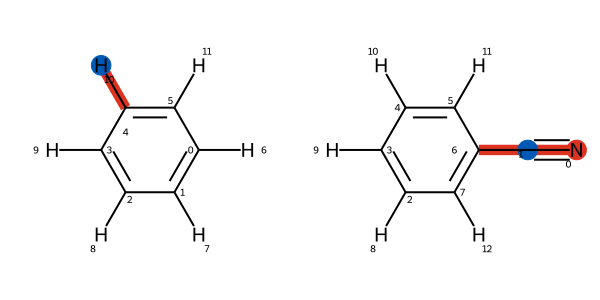

In [8]:
edges = [edge for edge in network.edges]
edge = edges[5]
edge

This network contains a set of 6 edges centered around the benzene molecule
which define the various atom mappings between the the transformation pairs.

We can visualise this network using the openfe `atommapping_network_plotting` 
method as shown below.

_Note: this visualisation can be used both in in a notebook or over a command line, however there are some performance issues when interacting within a notebook at the moment_

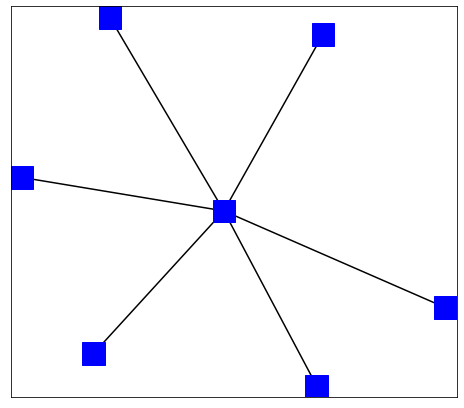

In [9]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(network)

Edges along the network can be accessed to recover the invidual molecules
involved in that given alchemical tranformation, and the atom mapping between
the two ligands.

**Note: as can be seen in the example below, transformations are defined within OpenFE as going from molA to molB**

In [10]:
transform_edges = [edge for edge in network.edges]
print("molecule A smiles: ", transform_edges[0].molA.smiles)
print("molecule B smiles: ", transform_edges[0].molB.smiles)
print("map between molecule A and B: ", transform_edges[0].molA_to_molB)

molecule A smiles:  [H]c1c([H])c([H])c([H])c([H])c1[H]
molecule B smiles:  [H]Oc1c([H])c([H])c([H])c([H])c1[H]
map between molecule A and B:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 12, 11: 11}


We can also visualise the atom mappings by invoking the individual OpenFE
AtomMapping objects directly.

Here we show how to draw two mappings for benzene -> phenol and benzene -> anisole.

Unique atoms between each mapping are shown in red, and atoms which are mapped
but undergo element changes are shown in blue. Bonds which either involve atoms that are unique or undergo element changes are highlighted in red.

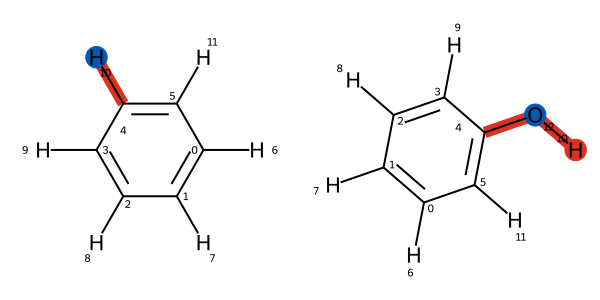

In [11]:
# Get the edge with phenol
edge = [edge for edge in network.edges if edge.molB.name == "phenol"][0]
edge

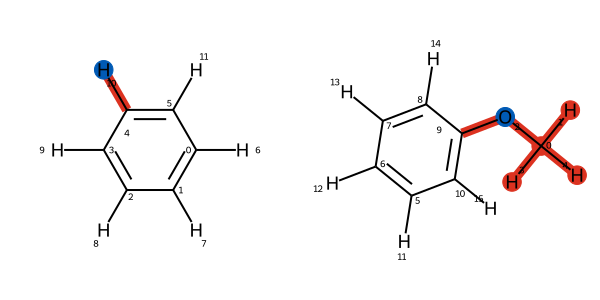

In [12]:
# Get edge for anisole
edge = [edge for edge in network.edges if edge.molB.name == "anisole"][0]
edge

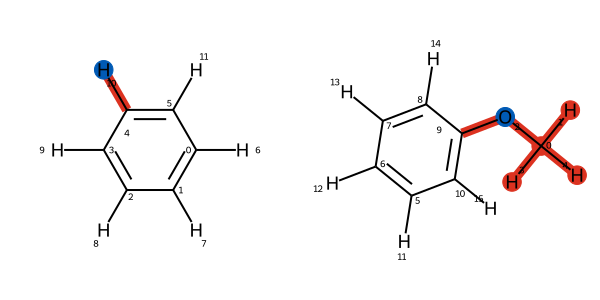

In [13]:
from IPython.display import Image

# mappings can also be saved to file if required
edge = [edge for edge in network.edges if edge.molB.name == "anisole"][0]
edge.draw_to_file('benzene-to-anisole.png')

# load it back for visualisation
Image("benzene-to-anisole.png")

### JNK1 ligand network

This is a rather simple atom mapping case. To show off the ability of the atom
mapping, here is a network for the Schrodinger JNK1 dataset.

In [14]:
# Load the jnk1 ligands
jnk1_sdf = Chem.SDMolSupplier('inputs/Jnk1_ligands.sdf', removeHs=False)

ligand_mols = [SmallMoleculeComponent(sdf) for sdf in jnk1_sdf]

# Create a network - reference molecule is ligand 0
jnk1_network = generate_radial_network(ligands=ligand_mols[1:],
                                       central_ligand=ligand_mols[0],
                                       mappers=[LomapAtomMapper(threed=True),])

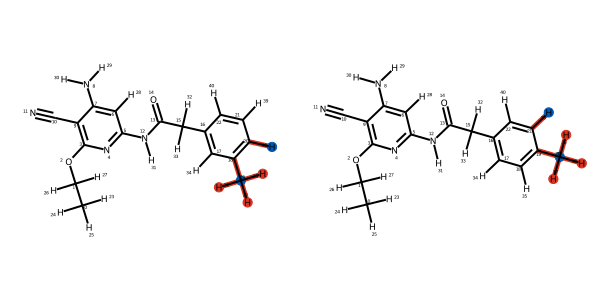

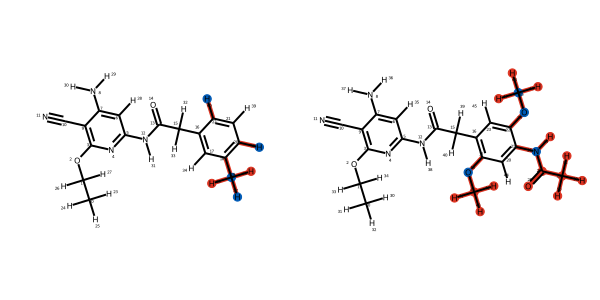

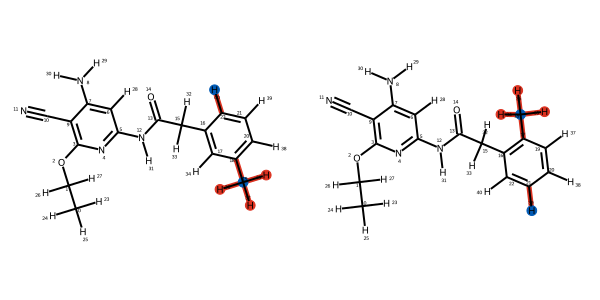

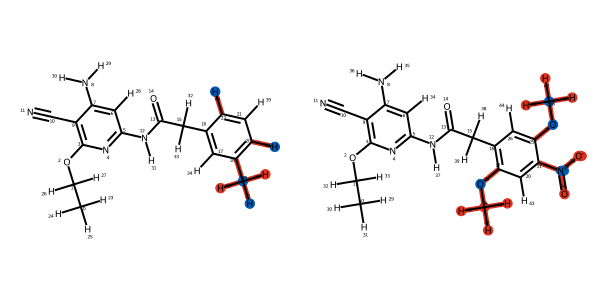

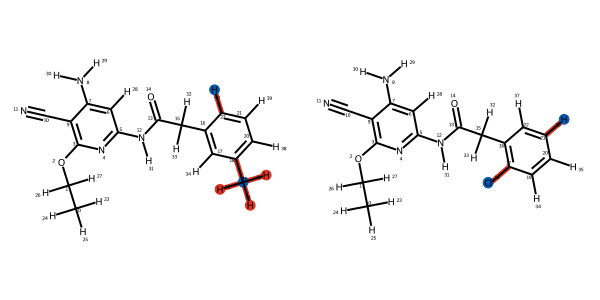

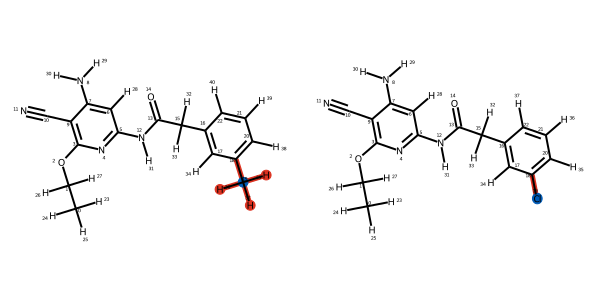

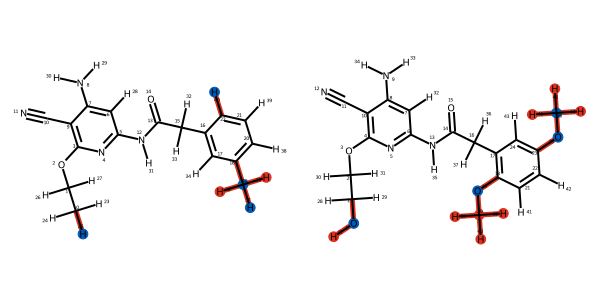

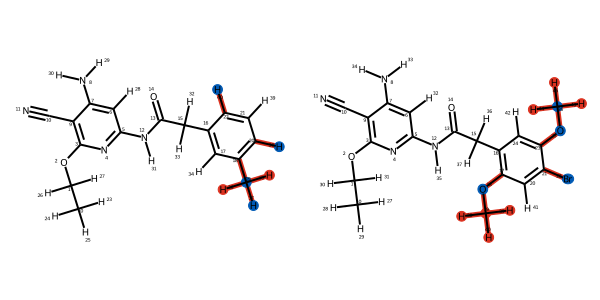

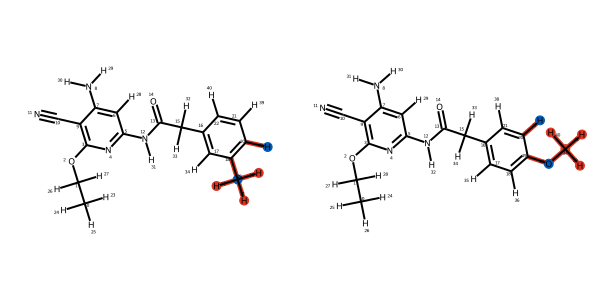

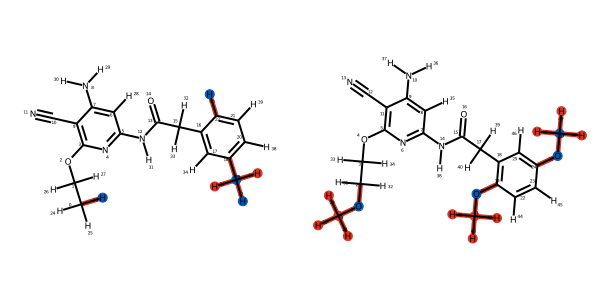

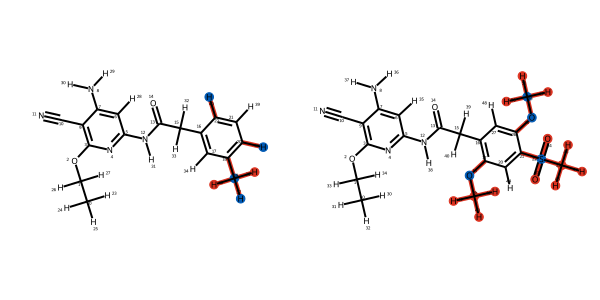

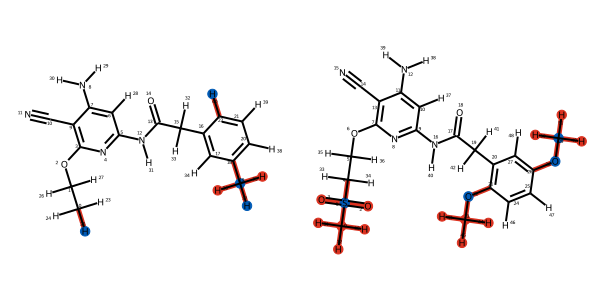

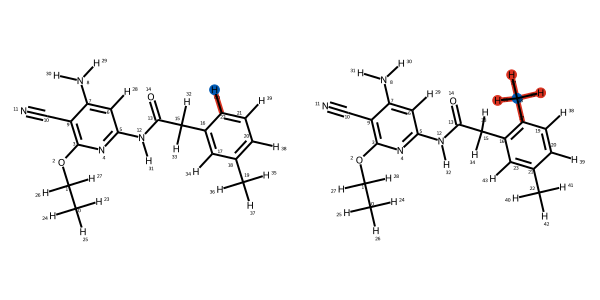

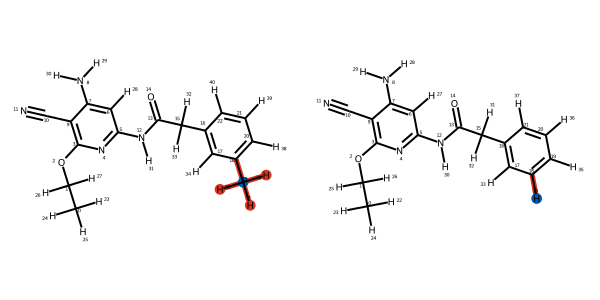

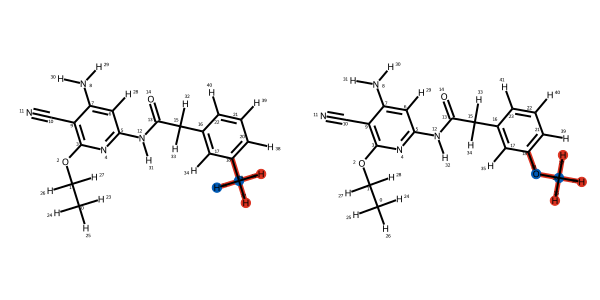

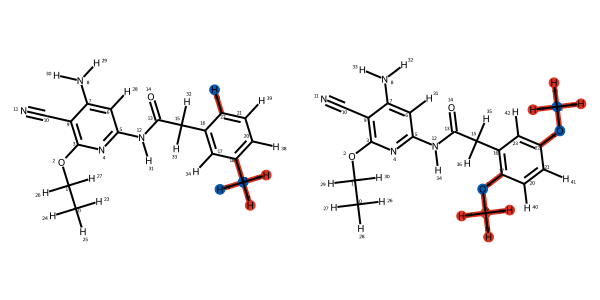

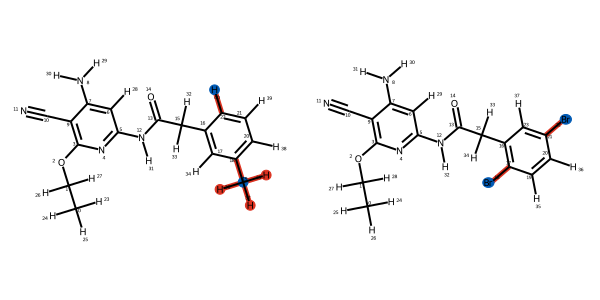

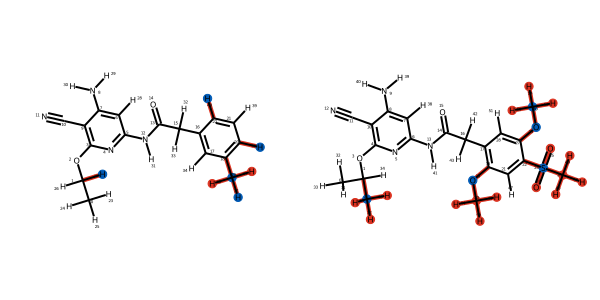

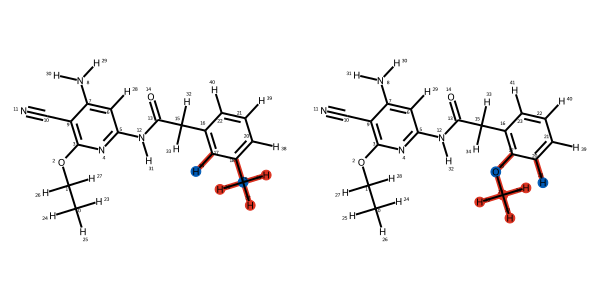

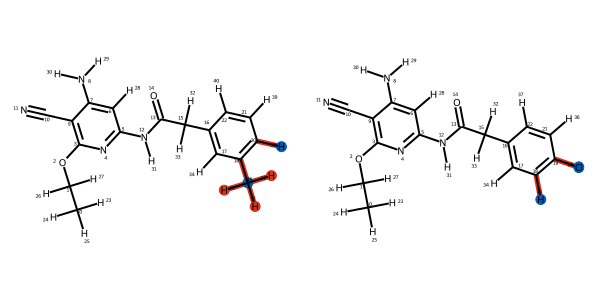

In [15]:
# Display all the atom mappings
jnk1_edges = [edge for edge in jnk1_network.edges]
for edge in jnk1_edges:
    display(edge)

### Storing the network

Created networks can easily be converted to (and also loaded from) as a GraphML representation.

This can allow users of OpenFE to store the network to disk for later use.

In [16]:
# Convert to graphml
with open("network_store.graphml", "w") as writer:
    writer.write(network.to_graphml())

In [17]:
from openfe.setup import Network

# load a new network from this graphml representation
with open('network_store.graphml', 'r') as file:
    network_data = file.read()
    
new_network = Network.from_graphml(network_data)

In [18]:
edges = [edge for edge in new_network.edges]
print(f"edge 0 molecule 1: {edges[0].molA.name}")
print(f"edge 0 molecule 2: {edges[0].molB.name}")
print(f"edge 0 mapping: {edges[0].molA_to_molB}")

edge 0 molecule 1: benzene
edge 0 molecule 2: phenol
edge 0 mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 12, 11: 11}


### The OpenFE CLI

The OpenFE toolkit also has a command line interface which we plan to add several convenience methods to.

For now functionality is limited to atom mapping, but it will be expanded upon as the project grows.

In [19]:
# Call help on the OpenFE CLI
!openfe --help

Usage: openfe [OPTIONS] COMMAND [ARGS]...

  This is the command line tool to provide easy access to functionality from
  the OpenFE Python library.

Options:
  --version   Show the version and exit.
  -h, --help  Show this message and exit.

Setup Commands:
  atommapping  Check the atom mapping of a given pair of ligands

Simulation Commands:
  echo  This shows up in ``openfe --help``


In [20]:
# Get an atom mapping using the CLI

!openfe atommapping --mapper LomapAtomMapper --mol inputs/benzene.sdf --mol inputs/styrene.sdf

/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy

/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/biggin/b131/bioc1523/software/anaconda/python3.6/2019.7/envs/openfe/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy

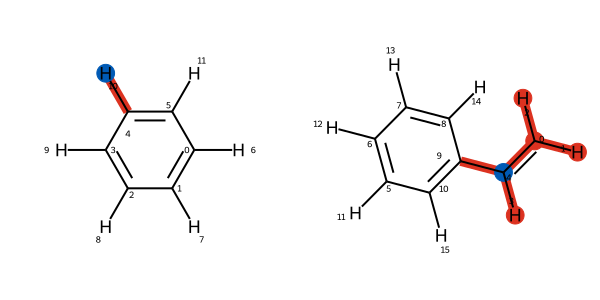

In [21]:
# We can also directly visualise the mapping
!openfe atommapping --mapper LomapAtomMapper --mol inputs/benzene.sdf --mol inputs/styrene.sdf --output test.png

Image('test.png')

## 3. Running a Relative Ligand Binding Free Energy Calculation

Now that we have a set of atom mappings defined, we know which atoms should
undergo alchemical transformations to capture the free energy cost of
transforming from one ligand to another.

To simulation this transformation we use the equilibrium RBFE protocol
implemented in OpenFE. This uses OpenMM to run a Perses-like relative
ligand binding free energy calculation using a single topology approach.

To achieve this simulation, the following steps need to happen:

1. Create OpenMM systems of both end states


2. Create a hybrid topology based on these defined endstates


3. Set an appropriate Lambda schedule


4. Set a MultiState reporter to write out appropriate coordinates and energies


5. Create an OpenMM sampler (in this case we will be using a replica exchange sampler)


6. Carry out the necessary simulation steps (minimization, equilibration, and production)


The `RelativeLigandTransform` class in `openfe.setup.methods.openmm.equil_rbfe_methods`
implements a means to achieve all the above with minimal intervention.

Here we work through its usage for the benzene -> phenol binding free energy
test case. As this involves both a relative binding free energy in solvent
and complex phases, two separate instances of `RelativeLigandTransform` will
be built and run.

**Note: the underlying components used for the creation of OpenMM hybrid
topologies and samplers is still in flux, originating mostly from Perses.
Please consider these to be in alpha with limited testing.**

### Defining the ChemicalSystems

`ChemicalSystems` are OpenFE containers which define the various components
which exist in a system of interest. You can consider these to be the nodes
along an alchemical network which are connected by edges which carry out
calculations along Alchemical states to get free energies.

`ChemicalSystems` take in three different things:

1. A dictionary of the chemical components (e.g. `SmallMoleculeComponent`,
   `ProteinComponent`, `SolventComponent`) defining the system.


2. Box vectors (optional), defining the shape and size of the unit cell of the
   system.


3. An identifier name (optional), for the `ChemicalSystem`. This is used as part
   of the hash identifier of the `ChemicalSystem`, and can help distinguish between
   otherwise comparable systems.

In the case of a relative ligand binding free energy calculation for benzene -> phenol,
four `ChemicalSystems` must be defined:

1. Benzene in complex with T4 lysozyme in a box of water


2. Phenol in complex with T4 lysozyme in a box of water


3. Benzene in a box of water


4. Phenol in a box of water


Here we will be passing the previously defined `SmallMoleculeComponents` for benzene
and phenol. We will also pass a `ProteinComponent` generated from the PDB file
present under `inputs/181L_mod_capped_protonated.pdb`. Finally, instead of passing
in a specific box of water, we will define a `SolventComponent` which will contain
the necessary information for OpenMM's `Modeller` class to add water and 0.15 M NaCl
around the solute when creating the OpenMM simulation objects.

In [22]:
# First let's define the Protein and Solvent Components which we will be using
from openfe.setup import SolventComponent, ProteinComponent
from openff.units import unit

protein = ProteinComponent.from_pdbfile('inputs/181L_mod_capped_protonated.pdb')

# Note: the distance from the solute to add water is not defined here but in the
# the relevant RBFE solver method
solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                           neutralize=True, ion_concentration=0.15*unit.molar)

In [23]:
# Extract the relevant edge for the benzene -> phenol transform in the radial graph
benz_to_phenol = [edge for edge in network.edges if edge.molB.name == "phenol"][0]

In [24]:
# Let's create the four ChemicalSystems
from openfe.setup import ChemicalSystem

benzene_complex = ChemicalSystem({'ligand': benz_to_phenol.molA,
                                  'solvent': solvent,
                                  'protein': protein,})
benzene_solvent = ChemicalSystem({'ligand': benz_to_phenol.molA,
                                  'solvent': solvent,})

phenol_complex = ChemicalSystem({'ligand': benz_to_phenol.molB,
                                 'solvent': solvent,
                                 'protein': protein,})
phenol_solvent = ChemicalSystem({'ligand': benz_to_phenol.molB,
                                 'solvent': solvent,})

### Defining the RBFE simulation settings

There are various different parameters which can be set to determine
how the RBFE simulation will take place. To allow for maximum
user flexibility, these are defined within
`openfe.setup.methods.openmm.equil_rbfe_methods` as a series of
settings objects which control the following:

1. `SystemSettings`: parameters defining the simulation system, including; nonbonded_method, cutoff, constraints, water constraints, and hydrogen mass.


2. `TopologySettings`: parameters defining the creation of the system topologies, including; force field, and solvent model.


3. `AlchemicalSettings`: parameters controlling the creation of the hybrid topology system, and the lambda schedule. This includes various parameters ranging from softcore parameters, through to the number of lambda windows to sample.


4. `OpenMMEngineSettings`: parameters determining how the OpenMM engine will execute the simulation. This mostly controls the compute platform which will be used to carry out the simulation.


5. `SamplerSettings`: parameters determining which equilibrium sampler and their various controls parameters. For now only a replica exchange sampler is available, but one using self-adjusted mixture sampling will be added soon.


6. `BarostatSettings`: parameters controling the creation of an OpenMM Monte Carlo barostat. Note: for now OpenFE only calculates RBFEs in NPT conditions. Support for NVT conditions may be added in the future.


7. `IntegratorSettings`: parameters controlling the `LangevinSplittingDynamicsMove` integrator used for simulation.


8. `SimulationSettings`: parameters controling the simulation plan, including the number of minimization steps, the length of the equilibration and production steps, the trajectory filename, write frequency, and which parts of the system to write coordinates for.


These various settings are combined together to create a `RelativeLigandTransformSettings` class. By default these settings use the values which are considered appropriate for RBFE calculations, however these are very system dependent and may not always be suitable for every case. A judicious choice of settings is always advised.

In [25]:
# Settings can be accessed from the various classes

from openfe.setup.methods.openmm.equil_rbfe_methods import (
    SystemSettings, TopologySettings, AlchemicalSettings,
    OpenMMEngineSettings, SamplerSettings, BarostatSettings,
    IntegratorSettings, SimulationSettings
)

# The documentation on each class can be accessed to know
# what parameters can be set
?SystemSettings

In [26]:
# Classes created without any arguments will use the default options
system = SystemSettings()
print(system)

constraints='HBonds' hydrogen_mass=None nonbonded_method='PME' nonbonded_cutoff=<Quantity(1.0, 'nanometer')> rigid_water=True remove_com=True


In [27]:
# Or specific arguments can be passed to override the defaults
# Here we set the nonbonded_cutoff to 1.2 nm
system = SystemSettings(nonbonded_cutoff=1.2 * unit.nanometer)
print(system)

constraints='HBonds' hydrogen_mass=None nonbonded_method='PME' nonbonded_cutoff=<Quantity(1.2, 'nanometer')> rigid_water=True remove_com=True


In [28]:
# A complete set of settings is created via the RelativeLigandTransformSettings class
from openfe.setup.methods.openmm.equil_rbfe_methods import RelativeLigandTransformSettings
from pprint import pp

# There are non-optional settings which need to be set
# we set them here
settings = RelativeLigandTransformSettings(
    system_settings=SystemSettings(
        constraints='HBonds',
    ),
    topology_settings=TopologySettings(
        forcefield = {'protein': 'amber99sb.xml',
                      'ligand': 'openff-2.0.0.xml',
                      'solvent': 'tip3p.xml'},
    ),
    alchemical_settings=AlchemicalSettings(),
    sampler_settings=SamplerSettings(),
    barostat_settings=BarostatSettings(),
    integrator_settings=IntegratorSettings(),
    simulation_settings=SimulationSettings(
        equilibration_length=2.0 * unit.nanosecond,
        production_length=5.0 * unit.nanosecond,
    ),
)

# Individual settings can be inspected directly
pp(settings.system_settings)

SystemSettings(constraints='HBonds', hydrogen_mass=None, nonbonded_method='PME', nonbonded_cutoff=<Quantity(1.0, 'nanometer')>, rigid_water=True, remove_com=True)


The `RelativeLigandTransform` class can directly populate the above set of default
settings through its `get_default_settings` class.

In [29]:
from openfe.setup.methods.openmm.equil_rbfe_methods import RelativeLigandTransform

complex_settings = RelativeLigandTransform.get_default_settings()

In [30]:
# Parameters can also be overriden after creation
# In this case, we'll reduce the equilibration length to 0.01 * nanosecond
# and the production to 0.05 * nanosecond in order to reduce the costs of
# running this notebook (in practice values of 2 and 5 nanoseconds
# respectively would be most appropriate)

complex_settings.simulation_settings.equilibration_length = 10 * unit.picosecond
complex_settings.simulation_settings.production_length = 50 * unit.picosecond

pp(complex_settings.simulation_settings)

SimulationSettings(equilibration_length=<Quantity(10, 'picosecond')>, production_length=<Quantity(50, 'picosecond')>, checkpoint_storage=None, minimization_steps=10000, output_filename='rbfe.nc', output_indices='all', checkpoint_interval=<Quantity(50, 'timestep')>)


In [31]:
# We will also create a copy of these settings and set the trajectory and checkpoint
# filenames to reflect the simulation phases (and avoid an overlap in naming)

import copy
solvent_settings = copy.deepcopy(complex_settings)

# Set the complex output file names
complex_settings.simulation_settings.output_filename = 'complex_rbfe.nc'
complex_settings.simulation_settings.checkpoint_storage = 'complex_rbfe_checkpoint.nc'

# Set the solvent output file names
solvent_settings.simulation_settings.output_filename = 'solvent_rbfe.nc'
solvent_settings.simulation_settings.checkpoint_storage = 'solvent_rbfe_checkpoint.nc'

In [32]:
# Again we can look at the contents of the settings to check what values are set
print(complex_settings.simulation_settings)

equilibration_length=<Quantity(10, 'picosecond')> production_length=<Quantity(50, 'picosecond')> checkpoint_storage='complex_rbfe_checkpoint.nc' minimization_steps=10000 output_filename='complex_rbfe.nc' output_indices='all' checkpoint_interval=<Quantity(50, 'timestep')>


### Creating the RelativeLigandTransform protocols

The RelativeLigandTransforms take the inputs ChemicalSystems for the two
end states, their atom mappining and the relevant settings in order to
setup and run the relative free energy calculation defining the ligand
transformation.

As previously detailed, we create two RelativeLigandTransforms defining
both the complex and solvent transformations

In [33]:
# complex transformation

complex_transform = RelativeLigandTransform(
    stateA=benzene_complex, stateB=phenol_complex,
    ligandmapping=benz_to_phenol,
    settings=complex_settings
)

solvent_transform = RelativeLigandTransform(
    stateA=benzene_solvent, stateB=phenol_solvent,
    ligandmapping=benz_to_phenol,
    settings=solvent_settings
)

### Simulating the RelativeLigandTransforms

Simulations can then be executed by calling the `.run()` method.

In the first instance we do a dry-run (which does everything but
starting the simulation) to make sure that the
hybrid openmm system can be constructed without any issues. 
Note: A successful call to `.run()` will return `True`.

In [34]:
# complex dry-run
complex_transform.run(dry=True, verbose=True)

INFO:	creating hybrid system
INFO:	Requested to generate parameters for residue <Residue 164 (benzene) of chain 1>
INFO:	Generating a residue template for [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	Requested to generate parameters for residue <Residue 11856 (phenol) of chain 4>
INFO:	Generating a residue template for [H][O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	creating hybrid system
INFO:	setting force field terms
INFO:	adding forces
INFO:	DONE
/biggin/b192/bioc1523/work2/OpenFE/openfe/openfe/setup/_rbfe_utils/multistate.py:85: UserWarning: setting number of replicas to number of states: 11
  warnings.warn(msg)


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

True

In [35]:
# solvent dry-run
solvent_transform.run(dry=True, verbose=True)

INFO:	creating hybrid system
INFO:	Requested to generate parameters for residue <Residue 0 (benzene) of chain 0>
INFO:	Generating a residue template for [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	Requested to generate parameters for residue <Residue 736 (phenol) of chain 3>
INFO:	Generating a residue template for [H][O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	creating hybrid system
INFO:	setting force field terms
INFO:	adding forces
INFO:	DONE
/biggin/b192/bioc1523/work2/OpenFE/openfe/openfe/setup/_rbfe_utils/multistate.py:85: UserWarning: setting number of replicas to number of states: 11
  warnings.warn(msg)


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

True

In [36]:
# Get rid of the created netcdf checkpoint files
# Note: in a future version of OpenFE this will be feasible directly via `run()`
!rm complex_rbfe_checkpoint.nc solvent_rbfe_checkpoint.nc

In [37]:
# Finally we can run the simulations

# First the complex transformation
complex_transform.run(verbose=True)

INFO:	creating hybrid system
INFO:	Requested to generate parameters for residue <Residue 164 (benzene) of chain 1>
INFO:	Generating a residue template for [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	Requested to generate parameters for residue <Residue 11856 (phenol) of chain 4>
INFO:	Generating a residue template for [H][O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	creating hybrid system
INFO:	setting force field terms
INFO:	adding forces
INFO:	DONE
/biggin/b192/bioc1523/work2/OpenFE/openfe/openfe/setup/_rbfe_utils/multistate.py:85: UserWarning: setting number of replicas to number of states: 11
  warnings.warn(msg)


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	minimizing systems
INFO:	equilibrating systems
INFO:	running production phase


True

In [38]:
# Next the ligand transformation
solvent_transform.run(verbose=True)

INFO:	creating hybrid system
INFO:	Requested to generate parameters for residue <Residue 0 (benzene) of chain 0>
INFO:	Generating a residue template for [H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	Requested to generate parameters for residue <Residue 736 (phenol) of chain 3>
INFO:	Generating a residue template for [H][O][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H] using openff-2.0.0.offxml
INFO:	creating hybrid system
INFO:	setting force field terms
INFO:	adding forces
INFO:	DONE
/biggin/b192/bioc1523/work2/OpenFE/openfe/openfe/setup/_rbfe_utils/multistate.py:85: UserWarning: setting number of replicas to number of states: 11
  warnings.warn(msg)
INFO:	minimizing systems


Please cite the following:

        Friedrichs MS, Eastman P, Vaidyanathan V, Houston M, LeGrand S, Beberg AL, Ensign DL, Bruns CM, and Pande VS. Accelerating molecular dynamic simulations on graphics processing unit. J. Comput. Chem. 30:864, 2009. DOI: 10.1002/jcc.21209
        Eastman P and Pande VS. OpenMM: A hardware-independent framework for molecular simulations. Comput. Sci. Eng. 12:34, 2010. DOI: 10.1109/MCSE.2010.27
        Eastman P and Pande VS. Efficient nonbonded interactions for molecular dynamics on a graphics processing unit. J. Comput. Chem. 31:1268, 2010. DOI: 10.1002/jcc.21413
        Eastman P and Pande VS. Constant constraint matrix approximation: A robust, parallelizable constraint method for molecular simulations. J. Chem. Theor. Comput. 6:434, 2010. DOI: 10.1021/ct900463w
        Chodera JD and Shirts MR. Replica exchange and expanded ensemble simulations as Gibbs multistate: Simple improvements for enhanced mixing. J. Chem. Phys., 135:194110, 2011. DOI:10.1063/

INFO:	equilibrating systems
INFO:	running production phase


True

## 5. Analysis

Finally now that we've run our simulations, let's go ahead and gather the free
energies for both phases.

This can be achieved by calling the `get_results()` methods of `RelativeLigandTransform`.

In [39]:
# Get the complex and solvent results
complex_results = complex_transform.get_results()
solvent_results = solvent_transform.get_results()

print(f"Complex dG: {complex_results.dG()}, err {complex_results.dG_error()}")
print(f"Solvent dG: {solvent_results.dG()}, err {solvent_results.dG_error()}")

Complex dG: 3.4460134628403902 kcal/mol, err 0.3590162014684479 kcal/mol
Solvent dG: 0.9926279094422851 kcal/mol, err 0.4746164070993469 kcal/mol
